In [ ]:
# Add the feedback-grape git submodule to the path
import sys, os
sys.path.append(os.path.abspath("./feedback-grape-dev"))

from feedback_grape.utils.operators import (
    sigmax,
    sigmay,
    sigmaz,
)
from feedback_grape.utils.states import basis
from feedback_grape.utils.tensor import tensor
from feedback_grape.fgrape import optimize_pulse, Gate
import jax
from jax import numpy as jnp
from numpy import flip
from library.utils.qubit_chain_1D import embed, calculate_expected_fidelity
from library.utils.plot_matrix import plot_matrix
from tqdm import tqdm
from jax.scipy.linalg import expm

n = 3 # Number of qubits
boundary = "open" # Boundary conditions: "open" or "periodic"
flip_site = 1 # Site to flip for initial state (0-indexed)

#plot_matrix(jnp.abs(H), title="Hamiltonian Matrix")

# Initialize ground state density matrix
rho_ground = basis(2**n, 0) @ basis(2**n, 0).conj().T

# Target state with single site excitation (qubit flipped)
psi = tensor(*[basis(2,0)]*flip_site + [basis(2,1)] + [basis(2,0)]*(n - flip_site - 1)) # Second qubit flipped
rho_excited = psi @ psi.conj().T
rho_excited /= jnp.trace(rho_excited) # Normalize

# Control operators (X,Y interaction between neighboring qubits and X rotation on last qubit which is the minimum control set to achieve full controllability)
def transport_unitary(params):
    J_x, J_y = params
    J_z = 0.0
    return expm(-1j*sum([
        -0.5*J_x*embed(sigmax(), i, n)@embed(sigmax(), (i+1)%n, n)
        -0.5*J_y*embed(sigmay(), i, n)@embed(sigmay(), (i+1)%n, n)
        -0.5*J_z*embed(sigmaz(), i, n)@embed(sigmaz(), (i+1)%n, n)
        for i in range(n-int(boundary=="open"))
    ])) # Interaction term

def rotation_unitary(params):
    alpha = params
    beta, gamma = 0.0, 0.0
    return expm(-1j*embed(sigmax(), n-1, n)*alpha + -1j*embed(sigmay(), n-1, n)*beta + -1j*embed(sigmaz(), n-1, n)*gamma) # Local X, Y and Z rotation on last qubit

# Measurement operator (projective measurement along z-axis on first qubit)
def projection_measurement_operator(measurement_outcome, params):
    return jnp.where(
        measurement_outcome == 1,
        tensor(jnp.eye(2**(n-1)), basis(2, 0)@basis(2, 0).conj().T),
        tensor(jnp.eye(2**(n-1)), basis(2, 1)@basis(2, 1).conj().T),
    )


# Assert that measurement operator is valid
assert jnp.allclose(projection_measurement_operator(-1, None) + projection_measurement_operator(1, None), jnp.eye(2**n)), "Measurement operators do not sum to identity"

fidelity_lists  = []
fidelity_labels = []

In [3]:
# Run this to perform multiple experiments
best_result = None
for num_time_steps in range(1, 5): # Number of time steps to test
    print(f"Running for {num_time_steps} time steps")
    fidelity_list = []
    for i in tqdm(range(10)): # Number of random initializations to test
        measure_gate = Gate(
        gate = projection_measurement_operator,
        initial_params=jax.random.uniform(
                jax.random.PRNGKey(i),
                shape=(0,),  # No parameters for this measurement operator
                minval=-jnp.pi,
                maxval=jnp.pi,
                dtype=float,
            ),
            measurement_flag=True,
        )

        transport_gate = Gate(
            gate = transport_unitary,
            initial_params=jax.random.uniform(
                jax.random.PRNGKey(i),
                shape=(2,), # Two coupling parameters (X and Y) between each pair of neighboring qubits
                minval=-2.0,
                maxval=2.0,
                dtype=float,
            ),
            measurement_flag=False,
        )

        rotation_gate = Gate(
            gate = rotation_unitary,
            initial_params=jax.random.uniform(
                jax.random.PRNGKey(i),
                shape=(1,),  # One coupling parameter for local X rotation
                minval=-jnp.pi,
                maxval=jnp.pi,
                dtype=float,
            ),
            measurement_flag=False,
        )

        system_params = [measure_gate, rotation_gate, transport_gate]

        # Training
        num_of_iterations = 1000
        learning_rate = 0.02
        result = optimize_pulse(
            U_0=rho_ground,
            C_target=rho_excited,
            system_params=system_params,
            num_time_steps=num_time_steps,
            mode="lookup",
            goal="fidelity",
            max_iter=num_of_iterations,
            convergence_threshold=1e-6,
            learning_rate=learning_rate,
            evo_type="density",
            batch_size=8,
            eval_batch_size=10,
        )

        expected_fidelity = calculate_expected_fidelity(result.optimized_trainable_parameters["lookup_table"], num_time_steps, n, num_time_steps, rho_ground, rho_excited)
        expected_final_fidelity = expected_fidelity[-1]
        expected_final_fidelity = result.final_fidelity
        #if best_result is None or expected_final_fidelity > max(fidelity_list):
        #    best_result = result

        fidelity_list.append(expected_final_fidelity)

        print("number of iterations:", result.iterations, "final fidelity:", result.final_fidelity)
    
    print(f"max fidelity: {jnp.max(jnp.array(fidelity_list))}")
    fidelity_lists.append(fidelity_list)
    fidelity_labels.append(f"t={num_time_steps} (1)")

# Play a sound when done
import os
os.system('say "fertig"')

Running for 1 time steps


 10%|█         | 1/10 [00:01<00:13,  1.48s/it]

number of iterations: 103 final fidelity: 0.4999960721448055


 20%|██        | 2/10 [00:02<00:11,  1.49s/it]

number of iterations: 89 final fidelity: 0.49999076893343014


 30%|███       | 3/10 [00:04<00:09,  1.41s/it]

number of iterations: 78 final fidelity: 0.4993330453106179


 40%|████      | 4/10 [00:05<00:08,  1.40s/it]

number of iterations: 89 final fidelity: 0.4997800871637731


 50%|█████     | 5/10 [00:06<00:06,  1.36s/it]

number of iterations: 68 final fidelity: 0.49995442327961587


 60%|██████    | 6/10 [00:08<00:05,  1.37s/it]

number of iterations: 93 final fidelity: 0.49997321625567576


 70%|███████   | 7/10 [00:09<00:04,  1.38s/it]

number of iterations: 115 final fidelity: 0.4999976280339894


 80%|████████  | 8/10 [00:11<00:02,  1.40s/it]

number of iterations: 156 final fidelity: 0.4999994471062083


 90%|█████████ | 9/10 [00:12<00:01,  1.37s/it]

number of iterations: 67 final fidelity: 0.4991630017383134


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


number of iterations: 114 final fidelity: 0.49988187391928424
max fidelity: 0.4999994471062083
Running for 2 time steps


 10%|█         | 1/10 [00:04<00:43,  4.81s/it]

number of iterations: 1000 final fidelity: 0.7171596695647138


 20%|██        | 2/10 [00:07<00:28,  3.60s/it]

number of iterations: 171 final fidelity: 0.999887346008147


 30%|███       | 3/10 [00:11<00:26,  3.84s/it]

number of iterations: 739 final fidelity: 0.6961240795366783


 40%|████      | 4/10 [00:14<00:21,  3.51s/it]

number of iterations: 228 final fidelity: 0.999992483490135


 50%|█████     | 5/10 [00:17<00:16,  3.32s/it]

number of iterations: 167 final fidelity: 0.500017119288258


 60%|██████    | 6/10 [00:20<00:12,  3.11s/it]

number of iterations: 107 final fidelity: 0.9999346582846211


 70%|███████   | 7/10 [00:25<00:10,  3.64s/it]

number of iterations: 1000 final fidelity: 0.7769501957001491


 80%|████████  | 8/10 [00:27<00:06,  3.32s/it]

number of iterations: 68 final fidelity: 0.9970777595194176


 90%|█████████ | 9/10 [00:30<00:03,  3.13s/it]

number of iterations: 88 final fidelity: 0.7258025535389017


100%|██████████| 10/10 [00:33<00:00,  3.34s/it]


number of iterations: 98 final fidelity: 0.9999414128007678
max fidelity: 0.999992483490135
Running for 3 time steps


 10%|█         | 1/10 [00:07<01:10,  7.80s/it]

number of iterations: 1000 final fidelity: 0.8482870120392981


 20%|██        | 2/10 [00:15<01:00,  7.52s/it]

number of iterations: 1000 final fidelity: 0.980734165906632


 30%|███       | 3/10 [00:22<00:52,  7.44s/it]

number of iterations: 942 final fidelity: 1.0


 40%|████      | 4/10 [00:29<00:44,  7.40s/it]

number of iterations: 1000 final fidelity: 0.9998798441052478


 50%|█████     | 5/10 [00:37<00:36,  7.38s/it]

number of iterations: 1000 final fidelity: 0.9999330567431532


 60%|██████    | 6/10 [00:43<00:28,  7.08s/it]

number of iterations: 715 final fidelity: 0.9998548592942286


 70%|███████   | 7/10 [00:50<00:20,  6.95s/it]

number of iterations: 805 final fidelity: 0.9992168642656417


 80%|████████  | 8/10 [00:54<00:12,  6.21s/it]

number of iterations: 179 final fidelity: 0.999988365520785


 90%|█████████ | 9/10 [01:02<00:06,  6.56s/it]

number of iterations: 1000 final fidelity: 0.8815707807073804


100%|██████████| 10/10 [01:08<00:00,  6.86s/it]


number of iterations: 689 final fidelity: 0.9996598097629206
max fidelity: 1.0
Running for 4 time steps


 10%|█         | 1/10 [00:11<01:39, 11.00s/it]

number of iterations: 1000 final fidelity: 0.9979779376448805


 20%|██        | 2/10 [00:21<01:25, 10.70s/it]

number of iterations: 1000 final fidelity: 0.9987145146931792


 30%|███       | 3/10 [00:31<01:13, 10.54s/it]

number of iterations: 1000 final fidelity: 0.998217108041146


 40%|████      | 4/10 [00:38<00:55,  9.17s/it]

number of iterations: 280 final fidelity: 0.4999772535605371


 50%|█████     | 5/10 [00:47<00:45,  9.09s/it]

number of iterations: 695 final fidelity: 0.999998022646342


 50%|█████     | 5/10 [00:58<00:58, 11.69s/it]


KeyboardInterrupt: 

max fidelity: t=1 (1) 0.7758003451049262
max fidelity: t=2 (1) 0.8807923650287597
max fidelity: t=3 (1) 0.9802178071417723
max fidelity: t=4 (1) 0.9865192329448986
max fidelity: t=5 (1) 0.9973984614895361
max fidelity: t=1 (1) 0.775802540734723
max fidelity: t=2 (1) 0.8503159676521985
max fidelity: t=3 (1) 0.9115194601513048
max fidelity: t=4 (1) 0.9545492091507048
max fidelity: t=5 (1) 0.967116364928831


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

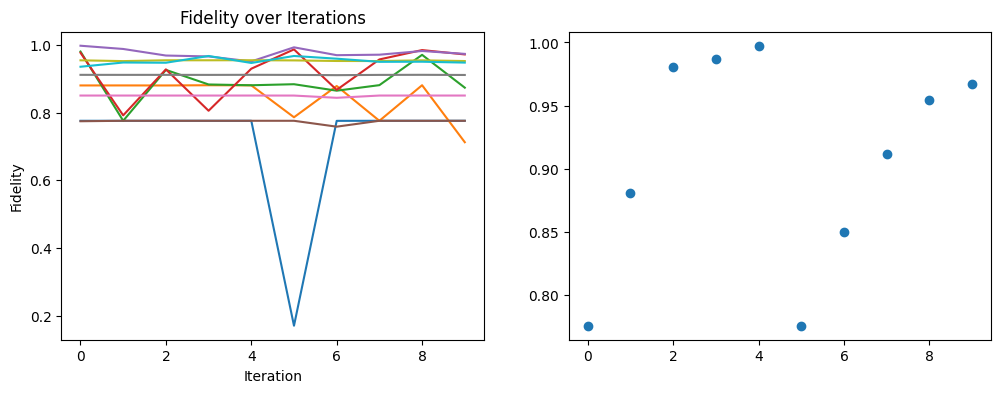

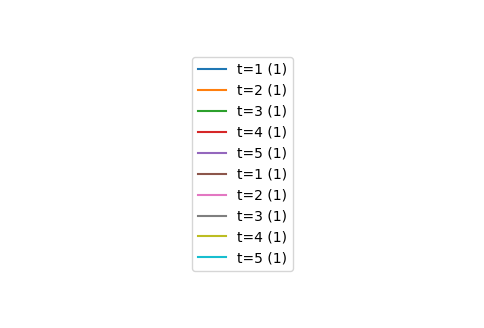

In [ ]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
for fidelities, label in zip(fidelity_lists, fidelity_labels):
    ax1.plot(fidelities, label=label)
    print(f"max fidelity: {label}", max(fidelities))
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Fidelity")
ax1.set_title("Fidelity over Iterations")

ax2.plot([max(fidelities) for fidelities in fidelity_lists], label=label, marker="o", linestyle='None')

# legend in seperate figure
fig2, ax2 = plt.subplots(1,1, figsize=(6,4))
ax2.legend(*ax1.get_legend_handles_labels(), loc='center')
ax2.axis('off')

In [ ]:
#fidelity_lists = fidelity_lists[6:]
#fidelity_labels = fidelity_labels[6:]

In [ ]:
# Store best result parameters in json format
import json

# Convert JAX/NumPy arrays to lists for JSON serialization
def to_serializable(obj):
    if hasattr(obj, "tolist"):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_serializable(x) for x in obj]
    return obj

params_serializable = to_serializable(best_result.optimized_trainable_parameters)
with open("best_result1_params.json", "w") as f:
    json.dump(params_serializable, f, indent=2)

In [ ]:
best_result.final_state.shape

(10, 8, 8)